<>:78: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\s'
C:\Users\amitm\AppData\Local\Temp\ipykernel_12064\220507575.py:78: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"Degraded (Blur + Noise, $\sigma$={sigma})")


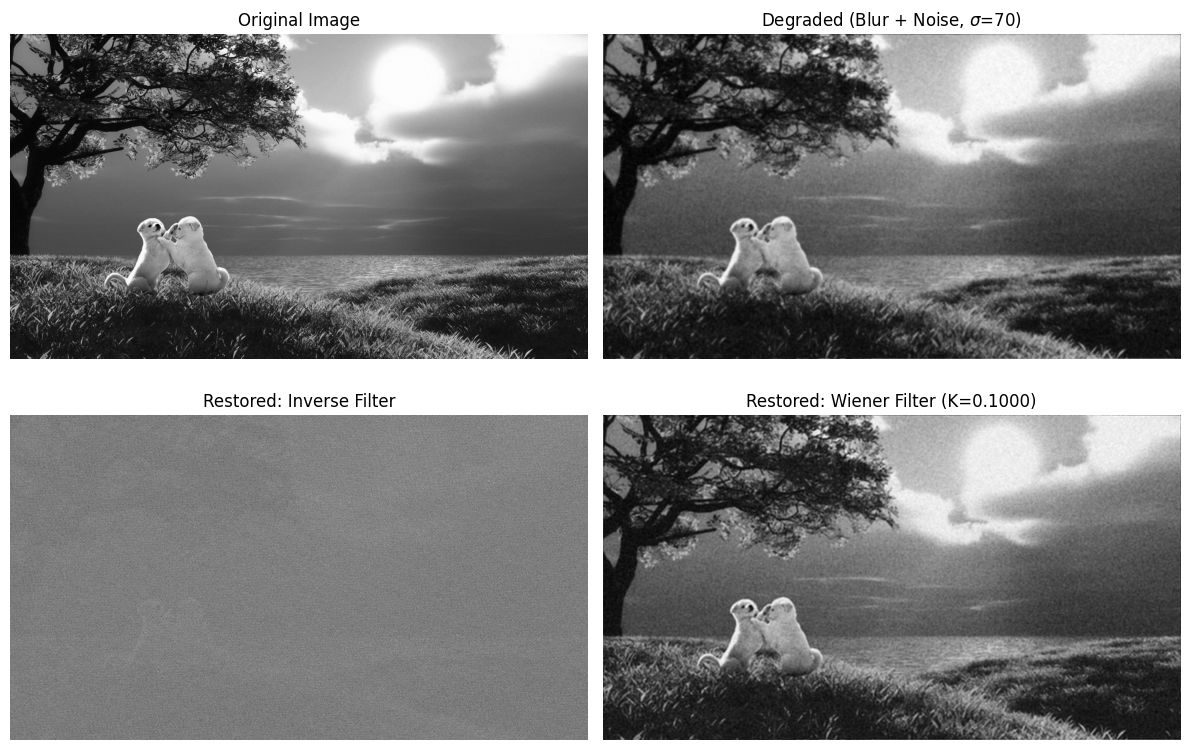

In [1]:
# on single image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys

# Step 1: Load your grayscale image
image_path = r"nature.jpg" 

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


if img is None:
    print(f"Error: Could not load image from path: {image_path}")
    print("Please check that the file exists and the path is correct.")
    sys.exit()

img = img.astype(np.float32)

#Step 2: Add Gaussian Noise
mean = 0

sigma = 70  
gaussian = np.random.normal(mean, sigma, img.shape)
noisy_img = img + gaussian
noisy_img = np.clip(noisy_img, 0, 255).astype(np.float32)

# Step 3: Apply Gaussian Blur
rows, cols = img.shape
psf_size = 21
sigma_blur = 5

# Create the Point Spread Function 
psf = np.zeros((rows, cols), dtype=np.float32)
gk1d = cv2.getGaussianKernel(psf_size, sigma_blur)
gk2d = gk1d @ gk1d.T
cy, cx = rows // 2, cols // 2
k_half = psf_size // 2
psf[cy - k_half:cy - k_half + psf_size, cx - k_half:cx - k_half + psf_size] = gk2d
psf /= psf.sum()

# Apply degradation in the frequency domain
H = np.fft.fft2(np.fft.ifftshift(psf))
IMG = np.fft.fft2(noisy_img)
degraded_freq = IMG * H
degraded = np.real(np.fft.ifft2(degraded_freq))
degraded = np.clip(degraded, 0, 255).astype(np.float32)

# Step 4: Perform and Plot Restoration
def perform_restoration_and_plot(K_factor):
   
    G = np.fft.fft2(degraded)
    H_conj = np.conj(H)
    H_mag2 = np.abs(H)**2
    
    # Inverse Filter
    eps = 1e-6
    H_inv = 1 / (H + eps)
    F_inv_freq = G * H_inv
    restored_inv = np.real(np.fft.ifft2(F_inv_freq))
    restored_inv = np.clip(restored_inv, 0, 255).astype(np.uint8)

    # Wiener Filter
    W = H_conj / (H_mag2 + K_factor)
    F_wiener_freq = W * G
    restored_wiener = np.real(np.fft.ifft2(F_wiener_freq))
    restored_wiener = np.clip(restored_wiener, 0, 255).astype(np.uint8)

    #Results
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(img.astype(np.uint8), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(degraded.astype(np.uint8), cmap='gray')
    plt.title(f"Degraded (Blur + Noise, $\sigma$={sigma})")
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(restored_inv, cmap='gray')
    plt.title("Restored: Inverse Filter")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(restored_wiener, cmap='gray')
    plt.title(f"Restored: Wiener Filter (K={K_factor:.4f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# With higher noise, a larger K value is often needed to suppress it.
FIXED_K_FACTOR = 0.1
perform_restoration_and_plot(FIXED_K_FACTOR)

In [3]:
!pip install kaggle kagglehub

In [39]:
import kagglehub

# Download butterfly dataset 
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")

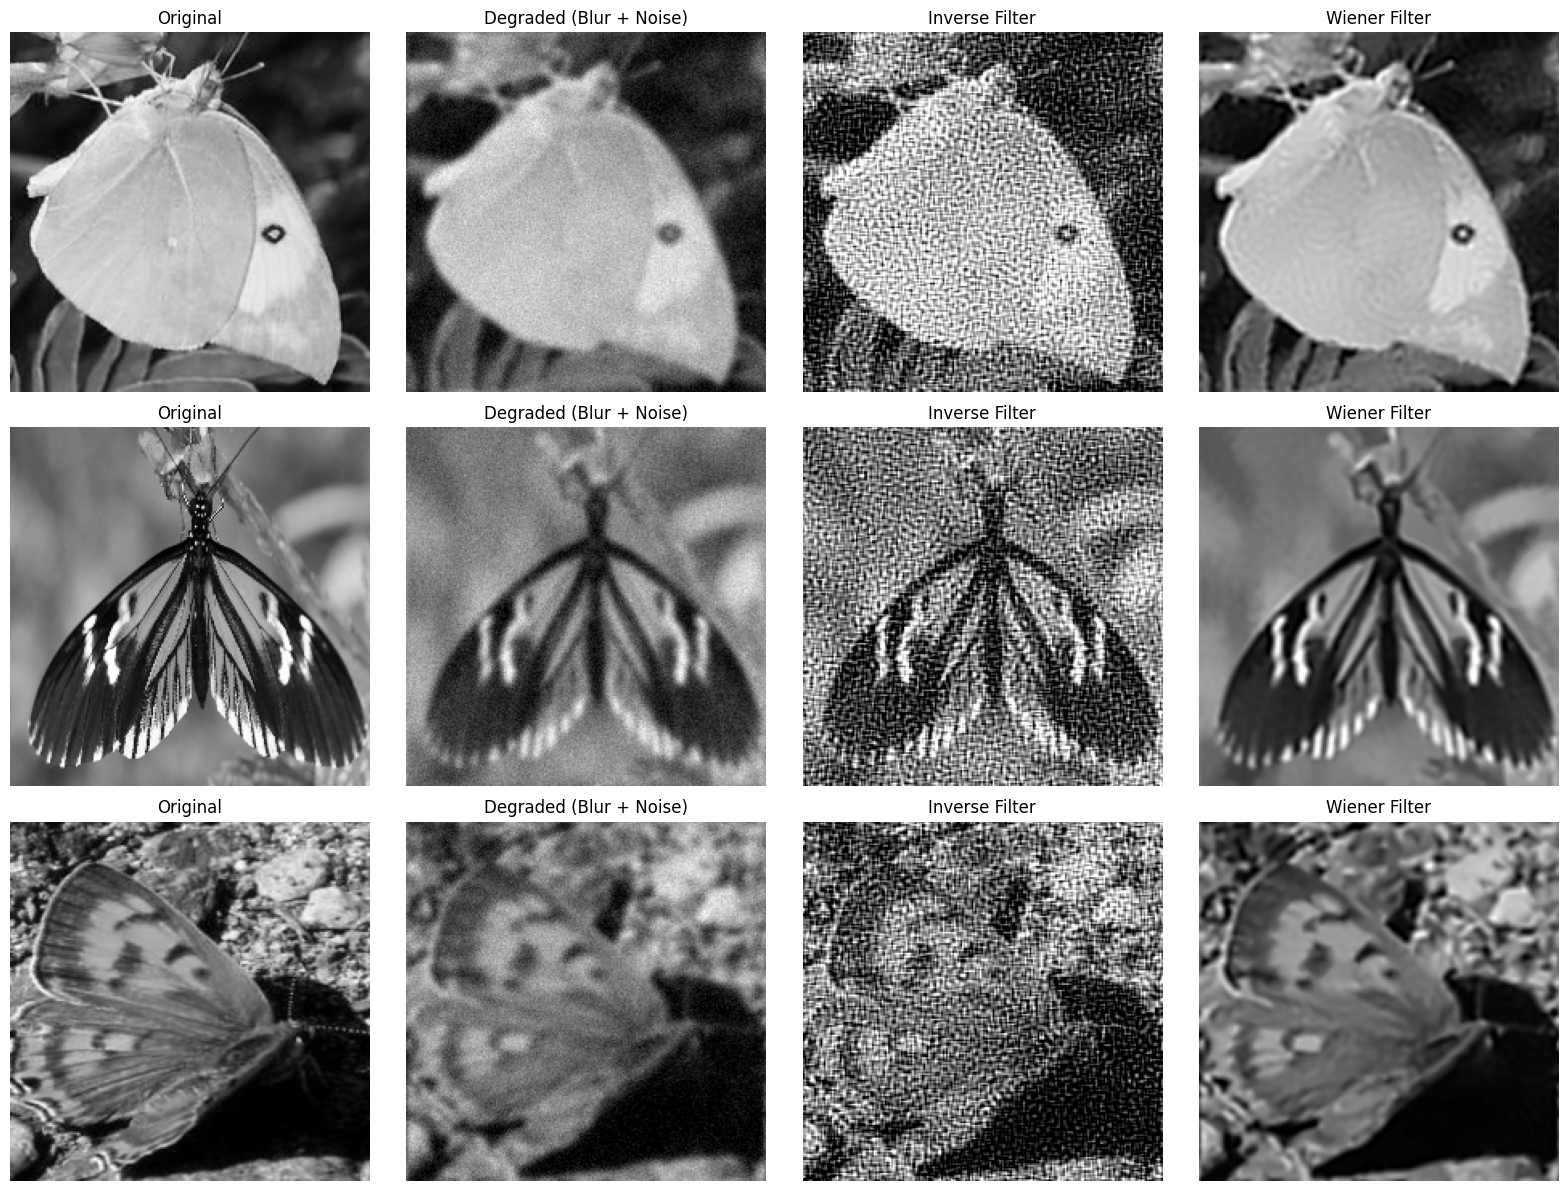

In [43]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import wiener


dataset_path = os.path.join(path, "train")
num_images_to_show = 3

sigma_noise = 10      # noise std deviation
psf_size = 9          # blur kernel size
sigma_blur = 2.0      # blur strength
denoise_strength = 10 # for fastNlMeansDenoising

#Helper Functions
def make_psf(shape, psf_size, sigma_blur):
    """Centered Gaussian PSF same size as image"""
    gk1d = cv2.getGaussianKernel(psf_size, sigma_blur)
    gk2d = gk1d @ gk1d.T
    psf = np.zeros(shape, dtype=np.float32)
    cy, cx = shape[0] // 2, shape[1] // 2
    k = psf_size // 2
    psf[cy - k:cy - k + psf_size, cx - k:cx - k + psf_size] = gk2d
    psf /= psf.sum()
    return psf

#Restoration Pipeline
def hybrid_wiener_restoration(img, psf, sigma_noise):
    
    # FFT Wiener filter
    img_f = np.fft.fft2(img)
    psf_f = np.fft.fft2(np.fft.ifftshift(psf))
    psf_conj = np.conj(psf_f)
    psf_mag2 = np.abs(psf_f) ** 2

    # Adaptive K based on noise power
    K = (sigma_noise ** 2) / np.var(img)
    wiener_filter = psf_conj / (psf_mag2 + K)
    restored = np.real(np.fft.ifft2(img_f * wiener_filter))
    restored = np.clip(restored, 0, 255).astype(np.float32)

    # Spatial denoising (non-local means)
    restored_denoised = cv2.fastNlMeansDenoising(
        restored.astype(np.uint8), None,
        h=denoise_strength, templateWindowSize=7, searchWindowSize=21
    ).astype(np.float32)

    # Unsharp masking for edge enhancement
    blurred = cv2.GaussianBlur(restored_denoised, (0, 0), 2)
    sharpened = cv2.addWeighted(restored_denoised, 1.5, blurred, -0.5, 0)
    return np.clip(sharpened, 0, 255).astype(np.uint8)


original_images, degraded_images, inv_images, wiener_images = [], [], [], []

for i, file in enumerate(os.listdir(dataset_path)):
    if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    if i >= num_images_to_show:
        break

    img = cv2.imread(os.path.join(dataset_path, file), cv2.IMREAD_GRAYSCALE).astype(np.float32)

    # Blur
    psf = make_psf(img.shape, psf_size, sigma_blur)
    H = np.fft.fft2(np.fft.ifftshift(psf))
    blurred = np.real(np.fft.ifft2(np.fft.fft2(img) * H))

    # Add noise
    noise = np.random.normal(0, sigma_noise, img.shape)
    degraded = np.clip(blurred + noise, 0, 255)

    # Inverse Filter (for comparison)
    eps = 1e-3
    H_inv = np.conj(H) / (np.abs(H)**2 + eps)
    restored_inv = np.real(np.fft.ifft2(np.fft.fft2(degraded) * H_inv))
    restored_inv = np.clip(restored_inv, 0, 255)

    # Improved Wiener Restoration
    restored_wiener = hybrid_wiener_restoration(degraded, psf, sigma_noise)

    original_images.append(img.astype(np.uint8))
    degraded_images.append(degraded.astype(np.uint8))
    inv_images.append(restored_inv.astype(np.uint8))
    wiener_images.append(restored_wiener)

#DISPLAY
fig, axes = plt.subplots(num_images_to_show, 4, figsize=(16, 4*num_images_to_show))
for idx in range(num_images_to_show):
    axes[idx, 0].imshow(original_images[idx], cmap='gray'); axes[idx, 0].set_title("Original")
    axes[idx, 1].imshow(degraded_images[idx], cmap='gray'); axes[idx, 1].set_title("Degraded (Blur + Noise)")
    axes[idx, 2].imshow(inv_images[idx], cmap='gray'); axes[idx, 2].set_title("Inverse Filter")
    axes[idx, 3].imshow(wiener_images[idx], cmap='gray'); axes[idx, 3].set_title("Wiener Filter")
    for j in range(4): axes[idx, j].axis('off')

plt.tight_layout()
plt.show()
